In [1]:
from dolfinx import default_scalar_type
from dolfinx.fem import (dirichletbc, Function, FunctionSpace, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.plot import vtk_mesh
from mpi4py import MPI
from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner)
import meshio
import gmsh
import numpy as np
import pyvista
import warnings

f_outer = lambda x: 3 # kappa in large cells
f_inner = lambda x: 47 # kappa in small cells

n = 2 # number of subdomain per row/column
d = 1.0/n
lc_outer = 1e-2 * 5
lc_inner = 1e-2 * 1

warnings.filterwarnings("ignore") # pyvista trame module not found

In [2]:
gmsh.initialize()

gmsh.option.setNumber("General.Verbosity", 2)

proc = MPI.COMM_WORLD.rank
outer_tags, outer_marker = [], 1
inner_tags, inner_marker = [], 2
ones, others = [], []
boundary_tags, boundary_marker = [], 1
if proc == 0:
    for i in range(n):
        for j in range(n):
            # We create one large cell, and one small cell within it
            #tag1 = i*n+j
            #tag2 = i*n+j + n*n

            # Create inner rectangle
            #gmsh.model.occ.addRectangle(d*(i+0.5), d*(j+0.5), 0, d*3/8, d*3/8, tag=tag2)
            p1 = gmsh.model.occ.addPoint(d*(i+0.500), d*(j+0.500), 0, lc_inner)
            p2 = gmsh.model.occ.addPoint(d*(i+0.875), d*(j+0.500), 0, lc_inner)
            p3 = gmsh.model.occ.addPoint(d*(i+0.875), d*(j+0.875), 0, lc_inner)
            p4 = gmsh.model.occ.addPoint(d*(i+0.500), d*(j+0.875), 0, lc_inner)
            l1 = gmsh.model.occ.addLine(p1, p2)
            l2 = gmsh.model.occ.addLine(p2, p3)
            l3 = gmsh.model.occ.addLine(p3, p4)
            l4 = gmsh.model.occ.addLine(p4, p1)

            cl_inner = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
            ps_inner = gmsh.model.occ.addPlaneSurface([cl_inner])

            # Create outer rectangle
            #gmsh.model.occ.addRectangle(d*i, d*j, 0, d, d, tag=tag1)
            p1 = gmsh.model.occ.addPoint(d*i, d*j, 0, lc_outer)
            p2 = gmsh.model.occ.addPoint(d*(i+1), d*j, 0, lc_outer)
            p3 = gmsh.model.occ.addPoint(d*(i+1), d*(j+1), 0, lc_outer)
            p4 = gmsh.model.occ.addPoint(d*i, d*(j+1), 0, lc_outer)
            l1 = gmsh.model.occ.addLine(p1, p2)
            l2 = gmsh.model.occ.addLine(p2, p3)
            l3 = gmsh.model.occ.addLine(p3, p4)
            l4 = gmsh.model.occ.addLine(p4, p1)

            cl_outer = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
            ps_outer = gmsh.model.occ.addPlaneSurface([cl_outer, cl_inner])
            
            # We add the rectangles in the subdomain list
            outer_tags.append(ps_outer)
            inner_tags.append(ps_inner)

            # We add the right rectangles to right list for fragmenting
            if (i+j)%2 == 0:
                ones.append((2, ps_outer))
                others.append((2, ps_inner))
            else:
                ones.append((2, ps_inner))
                others.append((2, ps_outer))
            
    gmsh.model.occ.fragment(ones, others)
    
    gmsh.model.occ.synchronize()
    
    #print(outer_tags)
    #print(inner_tags)
    gmsh.model.addPhysicalGroup(2, outer_tags, outer_marker)
    gmsh.model.addPhysicalGroup(2, inner_tags, inner_marker)
    
    # Tag the dirichlet boundary
    for line in gmsh.model.getEntities(dim=1):
        com = gmsh.model.occ.getCenterOfMass(line[0], line[1])
        if np.isclose(com[0], 0.0) or np.isclose(com[0], 1.0) or np.isclose(com[1], 0.0) or np.isclose(com[1], 1.0):
            boundary_tags.append(line[1])
    gmsh.model.addPhysicalGroup(1, boundary_tags, boundary_marker)
    
    gmsh.model.mesh.generate(2)
    #gmsh.model.mesh.refine()
    gmsh.write("PS/mesh.msh")
gmsh.finalize()

In [3]:
# We read in MSH files with DOLFINx, which will read them in on a single process,
# and then distribute them over the available ranks in the MPI communicator.
#  mesh, cell_markers, facet_markers = gmshio.read_from_msh("PS/mesh.msh", MPI.COMM_WORLD, gdim=2)

# A convenience function for extracting data for a single cell type, and creating a new meshio mesh,
# including physical markers for the given type.
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read": [cell_data.astype(np.int32)]})
    return out_mesh

# We have now written the mesh and the cell markers to one file, and the facet markers in a separate file.
# We can now read this data in DOLFINx using XDMFFile.read_mesh and XDMFFile.read_meshtags.
# The dolfinx.MeshTags stores the index of the entity, along with the value of the marker in two one dimensional arrays.
if proc == 0:
    # Read in mesh
    msh = meshio.read("PS/mesh.msh")

    # Create and save one file for the mesh, and one file for the facets
    triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
    line_mesh = create_mesh(msh, "line", prune_z=True)
    meshio.write("PS/mesh.xdmf", triangle_mesh)
    meshio.write("PS/mt.xdmf", line_mesh)
MPI.COMM_WORLD.barrier()

# We read the mesh in parallel
with XDMFFile(MPI.COMM_WORLD, "PS/mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)
with XDMFFile(MPI.COMM_WORLD, "PS/mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")
# print(ft.indices)
# print(ft.values)

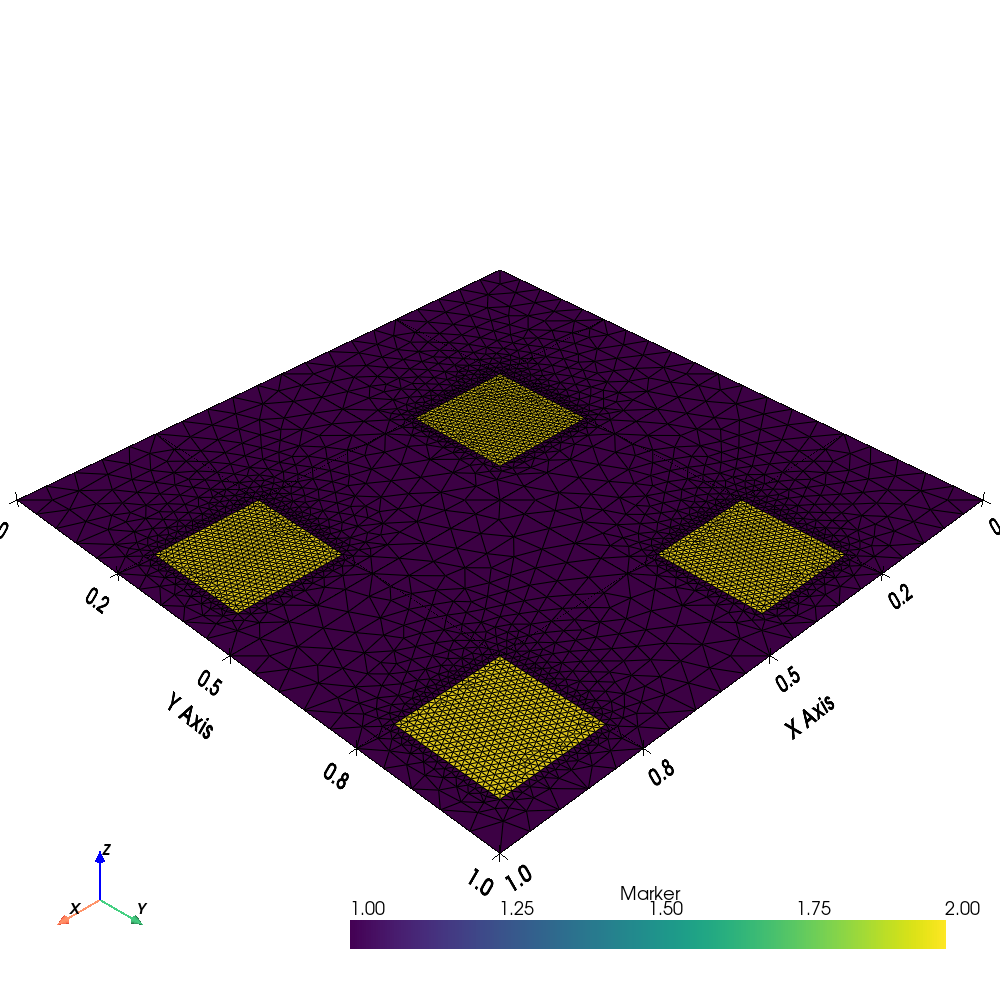

In [4]:
# We can now create our discontinuous function for tagging subdomains:
FS_tags = FunctionSpace(mesh, ("DG", 0))
q = Function(FS_tags)
outer_cells = ct.find(outer_marker)
q.x.array[outer_cells] = np.full_like(outer_cells, outer_marker, dtype=default_scalar_type)
inner_cells = ct.find(inner_marker)
q.x.array[inner_cells] = np.full_like(inner_cells, inner_marker, dtype=default_scalar_type)

# As the dolfinx.MeshTag contains a value for every cell in the
# geometry, we can attach it directly to the grid

topology, cell_types, x = vtk_mesh(mesh, mesh.topology.dim)
grid_q = pyvista.UnstructuredGrid(topology, cell_types, x)
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid_q.cell_data["Marker"] = ct.values[ct.indices < num_local_cells]
grid_q.set_active_scalars("Marker")

# pyvista.start_xvfb()
pq = pyvista.Plotter(window_size=[1000, 1000])
pq.show_axes()
pq.show_grid()
pq.add_mesh(grid_q, show_edges=True)
if not pyvista.OFF_SCREEN:
    pq.show()
else:
    figure = pq.screenshot("PS/subdomains_unstructured.png")

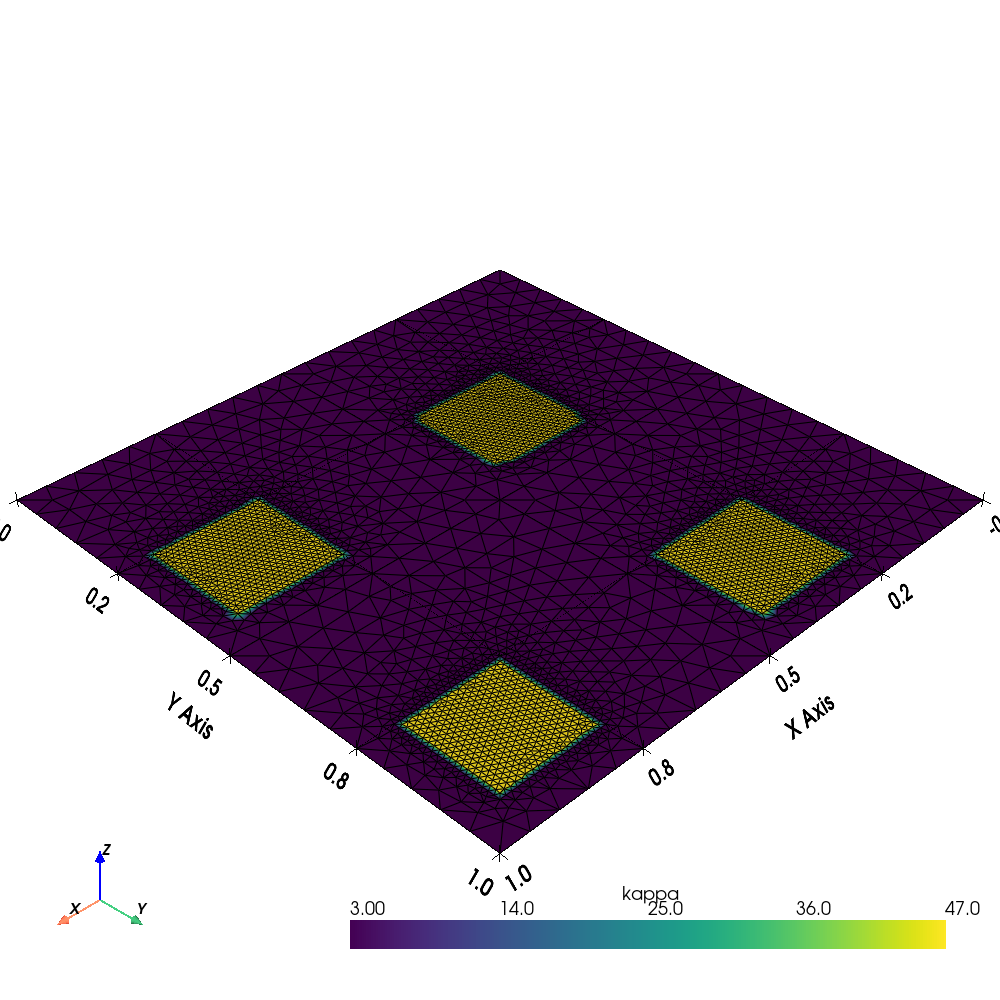

In [5]:
# Out of q, we can create an arbitratry kappa:
# We can now create our discontinuous function for tagging subdomains:
FS_kappa = FunctionSpace(mesh, ("Lagrange", 1))
fx, fy, fz = Function(FS_kappa), Function(FS_kappa), Function(FS_kappa)
fq, kappa = Function(FS_kappa), Function(FS_kappa)
fx.interpolate(lambda x: x[0])
fy.interpolate(lambda x: x[1])
fz.interpolate(lambda x: x[2])
fq.interpolate(q)
for i in range(len(kappa.x.array)):
    x = [fx.x.array[i], fy.x.array[i], fz.x.array[i]]
    if fq.x.array[i] == inner_marker:
        kappa.x.array[i] = f_inner(x)
    else:
        kappa.x.array[i] = f_outer(x)

# As the dolfinx.MeshTag contains a value for every cell in the
# geometry, we can attach it directly to the grid

grid_kappa = pyvista.UnstructuredGrid(*vtk_mesh(FS_kappa))
grid_kappa.point_data["kappa"] = kappa.x.array.real
grid_kappa.set_active_scalars("kappa")

# pyvista.start_xvfb()
p_kappa = pyvista.Plotter(window_size=[1000, 1000])
p_kappa.show_axes()
p_kappa.show_grid()
p_kappa.add_mesh(grid_kappa, show_edges=True)
if not pyvista.OFF_SCREEN:
    p_kappa.show()
else:
    figure = p_kappa.screenshot("PS/unstructured_kappa.png")

In [6]:
# We can also efficiently use the facet data ft to create the Dirichlet boundary condition:
FS_problem = FunctionSpace(mesh, ("Lagrange", 1))
u_bc = Function(FS_problem)
boundary_facets = ft.find(boundary_marker)
boundary_dofs = locate_dofs_topological(FS_problem, mesh.topology.dim - 1, boundary_facets)
bcs = [dirichletbc(default_scalar_type(0), boundary_dofs, FS_problem)]

# warning: some file left opened?
# ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.cache/fenics/libffcx_elements_519846f764d3489cd2c2264d8fd81cf81c907300.c' mode='x' encoding='UTF-8'>
#   open(c_filename, "x")

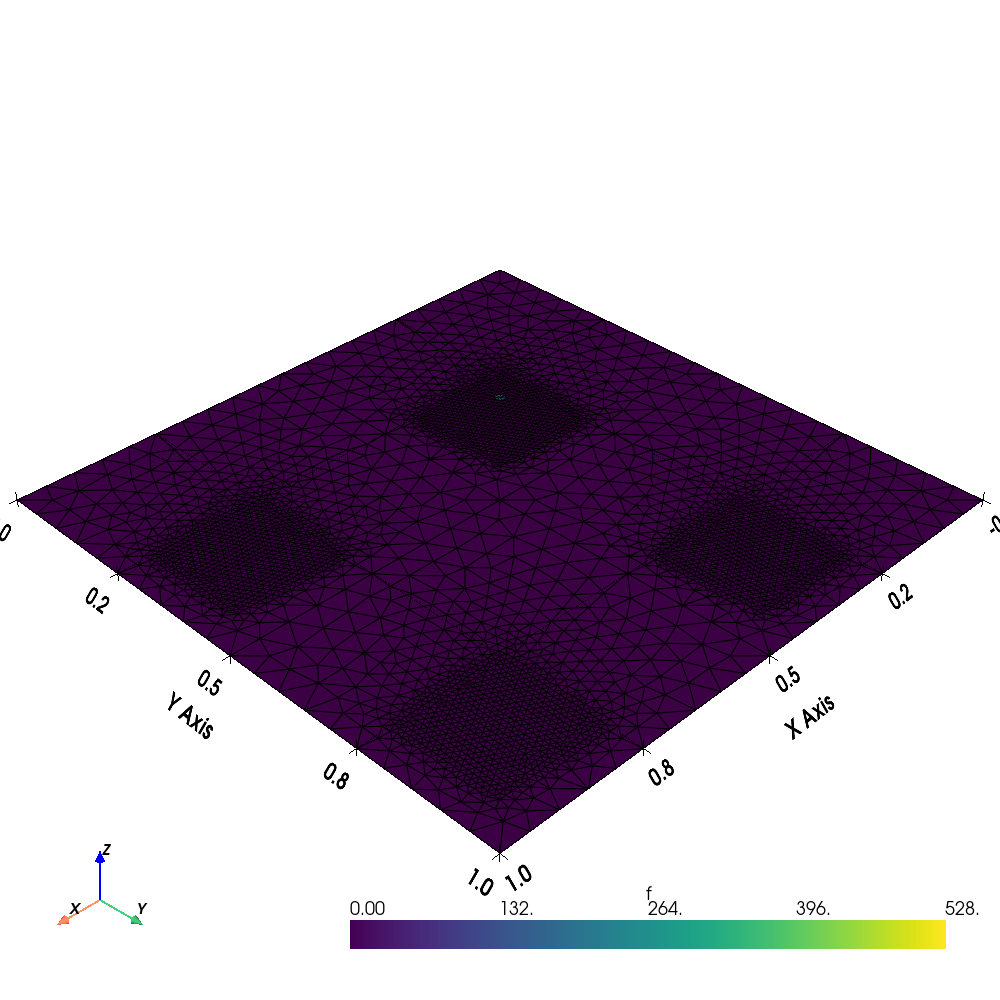

In [7]:
# Defining a quasi point source
FS_point_source = FunctionSpace(mesh, ("Lagrange", 1))
f = Function(FS_point_source)
a2 = np.power(10.0, -6)
x0, y0 = 0.3, 0.3
dirac = lambda x: 1/np.sqrt(a2 * np.pi) * np.exp(
    -( np.power(x[0] - x0, 2) + np.power(x[1] - y0, 2) ) / a2
)
f.interpolate(dirac)

grid_f = pyvista.UnstructuredGrid(*vtk_mesh(FS_point_source))
grid_f.point_data["f"] = f.x.array.real
grid_f.set_active_scalars("f")
pf = pyvista.Plotter(window_size=[1000, 1000])
pf.show_axes()
pf.show_grid()
pf.add_mesh(grid_f, show_edges=True)
if not pyvista.OFF_SCREEN:
    pf.show()
else:
    pf.screenshot("PS/unstructured_f.png")

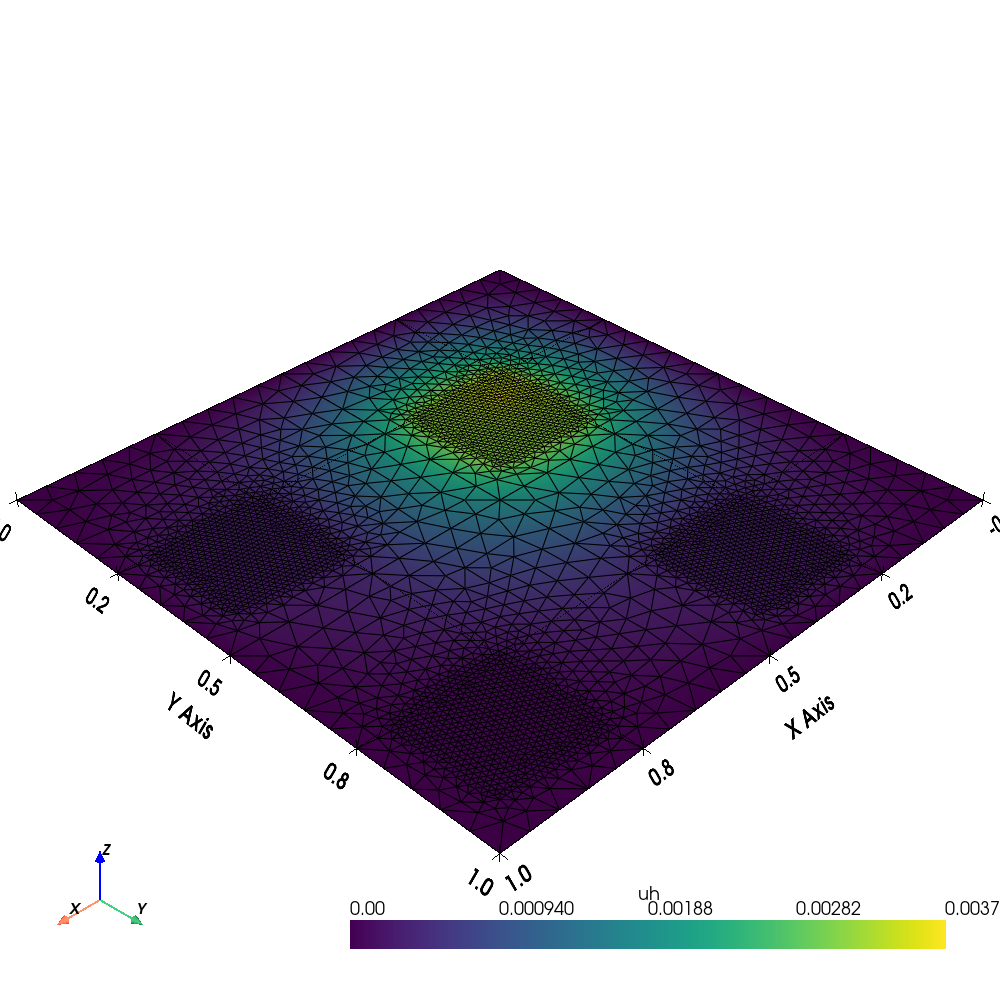

In [8]:
# Solving the problem
u, v, x = TrialFunction(FS_problem), TestFunction(FS_problem), SpatialCoordinate(mesh)
a = inner(kappa * grad(u), grad(v)) * dx
L = inner(f, v) * dx # inner(f, v) * dx

problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

grid_uh = pyvista.UnstructuredGrid(*vtk_mesh(FS_problem))
grid_uh.point_data["uh"] = uh.x.array.real
warped = grid_uh.warp_by_scalar("uh", factor=20)

puh = pyvista.Plotter(window_size=[1000, 1000])
puh.add_mesh(grid_uh, show_edges=True, show_scalar_bar=True, scalars="uh")
if not pyvista.OFF_SCREEN:
    puh.show_axes()
    puh.show_grid()
    puh.show()
else:
    puh.screenshot("PS/unstructured_u.png")

In [9]:
# Export
uh.name = "Heat"
with XDMFFile(mesh.comm, "PS/results.xdmf", "w", encoding=XDMFFile.Encoding.ASCII) as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(uh, 0.0)